# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, ensemble, metrics, linear_model, model_selection, inspection
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from shapely import geometry
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import semopy
import datetime as dt
from scipy import interpolate
from tqdm import tqdm
from pprint import pprint

import json
from shapely.geometry import box, mapping
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

import utils
# import pingouin as pg
import xgboost
# import shap
# shap.initjs()

import warnings
warnings.filterwarnings("ignore")

D:\dev\Anaconda3\envs\pygeo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
plt.rc('font', family='Arial', size=12)
# plt.rc('font', family='Calibri', size=12)
# plt.rcParams['axes.linewidth'] = 1
plt.rc('lines', linewidth=0.3)

# Load data

In [ ]:
df_top = pd.read_csv('./results/df_samples_topsoil_with_covariates_v6.csv')
df_sub = pd.read_csv('./results/df_samples_subsoil_with_covariates_v6.csv')

In [7]:
top_or_sub = 'topsoil'
# top_or_sub = 'subsoil'

if top_or_sub == 'topsoil':
    df = df_top.copy()
else:
    df = df_sub.copy()

In [11]:
biome_name_list = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts and xeric shrublands', 'Tundra', 'Croplands', 'Wetlands']

color_dict = {'Tropical forests': '#CC0000', 'Temperate forests': '#1E90FF', 'Boreal forests': '#A000FF', 'Tropical savannahs and grasslands': '#228B22',
              'Temperate grasslands and shrublands': '#9ACD32', 'Deserts and xeric shrublands': '#FA9418', 'Tundra': '#2FFFDA', 'Croplands': '#FF69B4', 'Wetlands': '#0000AA',
              'Global': '#A0A0A0'}

color_list = ['#CC0000', '#1E90FF', '#A000FF', '#228B22', '#9ACD32', '#FA9418', '#2FFFDA', '#FF69B4', '#0000AA']

cmap_biomes = mpl.colors.ListedColormap(color_list)

# Plot soil sample locations

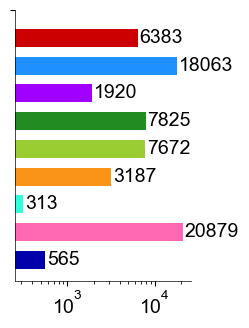

In [118]:
plt.figure(figsize=(2.7, 3.5), dpi=100)
plt.rc('font', family='Arial', size=14)
plt.rcParams['axes.linewidth'] = 0.5

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for j in range(len(biome_name_list)):
    i = len(biome_name_list) - j - 1
    sample_size = len(df[df['biome_type_name'] == biome_name_list[i]])
    # print(sample_size)
    plt.barh(biome_name_list[i], sample_size, height=0.65, color=color_dict[biome_name_list[i]])
    plt.text(x=sample_size*1.05, y=j-0.18, s=sample_size)
plt.yticks('')
plt.gca().set_xscale('log')
# plt.xlim(0, 18000)

plt.tight_layout()
# plt.savefig('./figure/sample_count_in_biomes_topsoil.png', dpi=600, bbox_inches='tight', transparent=True)
plt.savefig('./figure/sample_count_in_biomes_subsoil.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

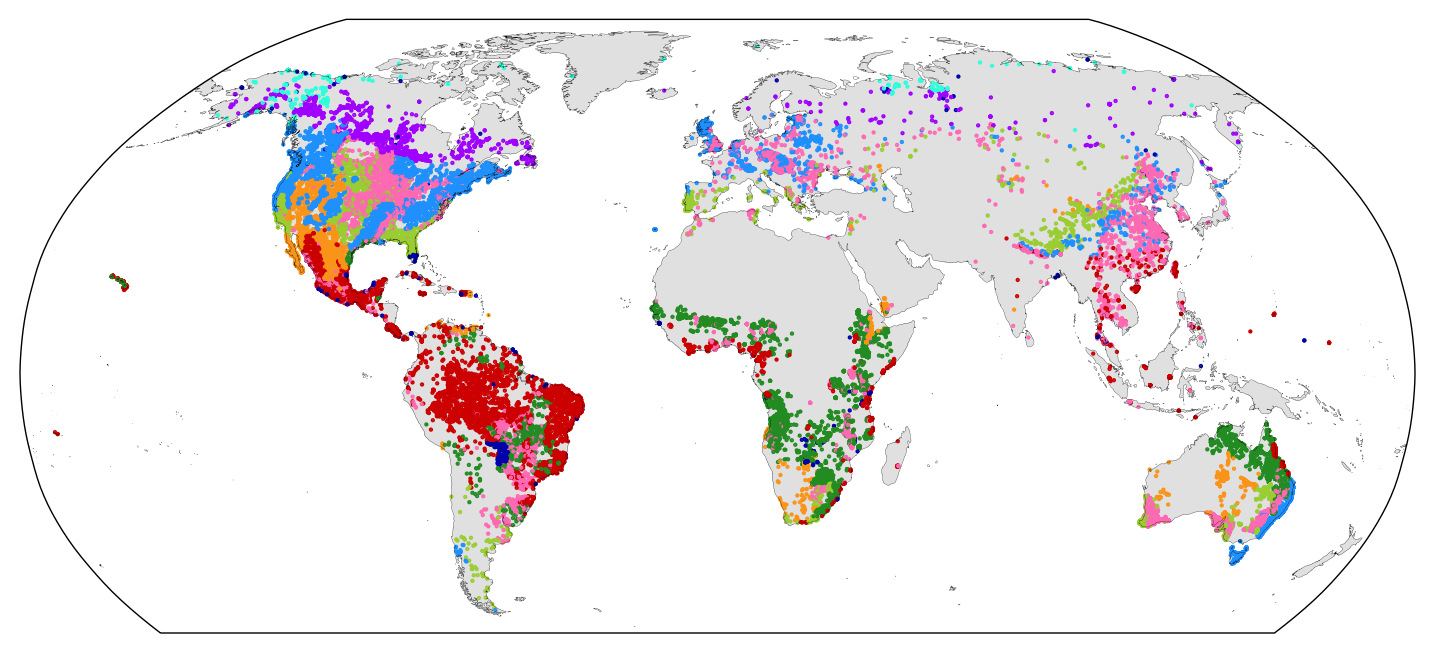

In [119]:
# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(9, 4), dpi=200, linewidth=0.5)
ax = plt.axes(projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False
# ax.outline_patch.set_linewidth(0.5)

ax.coastlines("50m", color="black", linewidth=0.1)
ax.add_feature(cfeature.LAND, color='#E0E0E0', linewidth=0)

samples_color_list = [color_dict[df['biome_type_name'][i]] for i in range(len(df))]
# for i in range(len(df)):
#     ax.plot(df['longitude'][i], df['latitude'][i], marker='o', markersize=1.5, markeredgecolor='none', markeredgewidth=0, color=color_dict[df['biome_type_name'][i]], transform=ccrs.PlateCarree())
plt_points = ax.scatter(df['longitude'], df['latitude'], c=samples_color_list,
                        marker='o', s=0.3,
                        transform=ccrs.PlateCarree())

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent)

# plt.savefig('./figure/sample_locations_topsoil_robin.jpg', dpi=600, bbox_inches='tight')
plt.savefig('./figure/sample_locations_subsoil_robin.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot histogram of the sample-level tovr

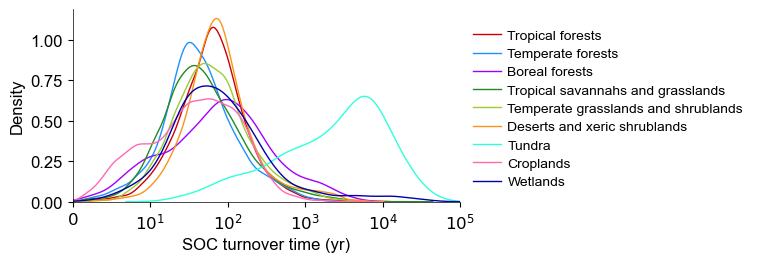

In [122]:
plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(5, 2.5), dpi=100, linewidth=0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i in range(len(biome_name_list)):
    tovr_list = np.array(df[df['biome_type_name'] == biome_name_list[i]]['tovr_log'])
    tovr_list = tovr_list[tovr_list > 0.1]

    sns.distplot(tovr_list, hist=False, kde=True, rug=False, label=biome_name_list[i], color=color_dict[biome_name_list[i]], kde_kws={'linewidth': 1})

# plt.xticks([0, 1, 2, 3, 4], ["$0$", "$10^{1}$", "$10^{2}$", "$10^{3}$", "$10^{4}$"])
plt.xticks([0, 1, 2, 3, 4, 5], ["$0$", "$10^{1}$", "$10^{2}$", "$10^{3}$", "$10^{4}$", "$10^{5}$"])

# plt.xlim(0, 3.5)
plt.xlim(0, 5)

plt.xlabel('SOC turnover time (yr)')
plt.legend(bbox_to_anchor=(1, 0, 0, 0.96), frameon=False,
           fontsize=10, labelspacing=0.4, handletextpad=0.5)

# plt.savefig('./figure/sample_tovr_density_distribution_topsoil.jpg', dpi=600, bbox_inches='tight')
plt.savefig('./figure/sample_tovr_density_distribution_subsoil.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot probability distribution of data

In [12]:
biome_name_list_with_global = ['Global'] + biome_name_list

In [13]:
colnames = ['profile_id', 'latitude', 'longitude', 'socs', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'is_permafrost', 'permafrost_EXTENT_id', 'crop_prop_maize', 'crop_prop_soybean', 'crop_prop_wheat_winter', 'crop_prop_wheat_spring', 'crop_prop_rice', 'crop_type_domain', 'crop_type_domain_id', 'crop_prop_sum', 'crop_prop_domain', 'biome_type', 'biome_type_name', 'harvest_index', 'frbnpp_0to30', 'frbnpp_30to100', 'geom_accuracy', 'dsds', 'country_name', 'npp_modis', 'rmf', 'agb', 'bgb', 'smp', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'aridity', 'elev', 'slp', 'cti', 'tri', 'vrm', 'roughness', 'tpi', 'spi', 'evi', 'pop', 'bdod_0to30', 'bdod_30to100', 'cec_0to30', 'cec_30to100', 'cfvo_0to30', 'cfvo_30to100', 'clay_0to30', 'clay_30to100', 'nitrogen_0to30', 'nitrogen_30to100', 'ocd_0to30', 'ocd_30to100', 'phh2o_0to30', 'phh2o_30to100', 'sand_0to30', 'sand_30to100', 'silt_0to30', 'silt_30to100', 'soc_0-5', 'soc_5-15', 'soc_15-30', 'soc_30-60', 'soc_60-100', 'soc_0to30', 'soc_30to100', 'cn_0to30', 'cn_30to100', 'fbgb', 'anpp', 'bnpp_0to30', 'bnpp_30to100', 'prop_fine_litter_in_anpp', 'leaf_type', 'c_input_by_fertilization_surface', 'c_input_by_fertilization_deep', 'c_input_by_fertilization', 'prop_residue_retention', 'tovr_apparent', 'tovr_stable', 'tovr_apparent_log', 'tovr_stable_log', 'tovr', 'tovr_log', 'MAT', 'MAP', 'SAND', 'SILT', 'CLAY', 'NITROGEN', 'C:N', 'CEC', 'pH', 'ELEV', 'ROUGH', 'VRM', 'TRI', 'CTI', 'SLP', 'SPI', 'TPI', 'CLAY+SILT']

df_top_ = df_top[colnames].copy()
df_top_['layer'] = 'Topsoil'

df_sub_ = df_sub[colnames].copy()
df_sub_['layer'] = 'Subsoil'

df_top_sub = pd.concat([df_top_, df_sub_], axis=0).reset_index(drop=True)

print(df_top_sub.shape)
print(list(df_top_sub.columns))
df_top_sub.head(2)

(162007, 155)
['profile_id', 'latitude', 'longitude', 'socs', 'UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3', 'NAME_3', 'GID_4', 'NAME_4', 'IncomeGroup', 'biome_OpenLandMap', 'lc_id_modis', 'lc_name_modis', 'OBJECTID', 'ECO_NAME', 'BIOME_NUM', 'BIOME_NAME', 'REALM', 'ECO_BIOME_', 'NNH', 'ECO_ID', 'SHAPE_LENG', 'SHAPE_AREA', 'NNH_NAME', 'COLOR', 'COLOR_BIO', 'COLOR_NNH', 'permafrost_CODE', 'permafrost_COMBO', 'permafrost_RELICT', 'permafrost_EXTENT', 'permafrost_CONTENT', 'permafrost_LANDFORM', 'is_permafrost', 'permafrost_EXTENT_id', 'crop_prop_maize', 'crop_prop_soybean', 'crop_prop_wheat_winter', 'crop_prop_wheat_spring', 'crop_prop_rice', 'crop_type_domain', 'crop_type_domain_id', 'crop_prop_sum', 'crop_prop_domain', 'biome_type', 'biome_type_name', 'harvest_index', 'frbnpp_0to30', 'frbnpp_30to100', 'geom_accuracy', 'dsds', 'country_name', 'npp_modis', 'rmf', 'agb', 'bgb', 'smp', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09'

,profile_id,latitude,longitude,socs,UID,GID_0,NAME_0,GID_1,NAME_1,GID_2,...,ELEV,ROUGH,VRM,TRI,CTI,SLP,SPI,TPI,CLAY+SILT,layer
0,36897,50.649889,4.666901,4.8,46721.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,...,142.0,4.239687,0.000082,1.561162,1.713883,0.940428,0.003967,-1.030786,89.783333,Topsoil
1,36898,50.583962,4.462114,5.0,46742.0,BEL,Belgium,BEL.3_1,Wallonie,BEL.3.1_1,...,135.0,5.028207,0.000074,1.303226,0.973978,0.929612,0.001878,0.191778,89.633333,Topsoil


## SOC stock

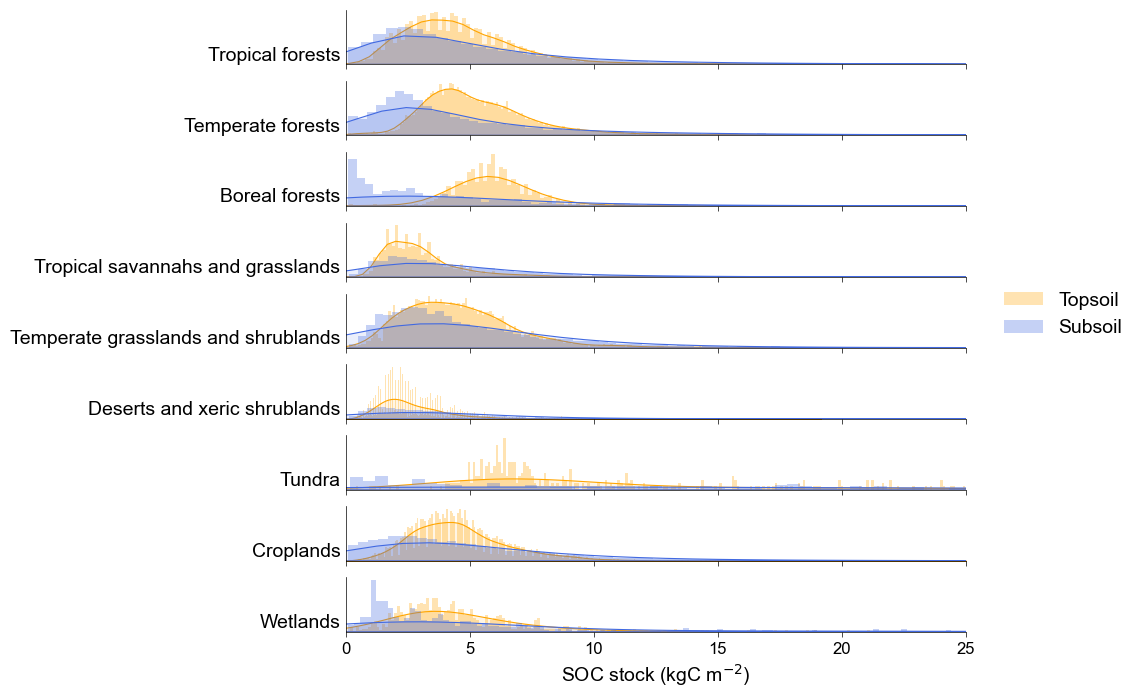

In [161]:
var_name = 'socs'
var_name_show = 'SOC stock (kgC m$^{-2}$)'

vmin = 0
vmax = 25
xticks = [0, 5, 10, 15, 20, 25]
bins = 500

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list_with_global[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list_topsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Topsoil'][var_name])
    value_list_subsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Subsoil'][var_name])
    
    sns.distplot(value_list_topsoil, hist=True, bins=bins, kde=True, rug=False, label='Topsoil', color='orange',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'orange', 'height': 0.1, 'linewidth': 0.01, 'clip_on': False, 'alpha': 1}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.1})
    sns.distplot(value_list_subsoil, hist=True, bins=bins, kde=True, rug=False, label='Subsoil', color='royalblue',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'royalblue', 'height': 0.1, 'linewidth': 0.01, 'clip_on': False, 'alpha': 1}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.1})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

    if plt_id == 5:
        plt.legend(loc='lower right', bbox_to_anchor=(1.28, -0.12), fontsize=14, frameon=False)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}_with_hist.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

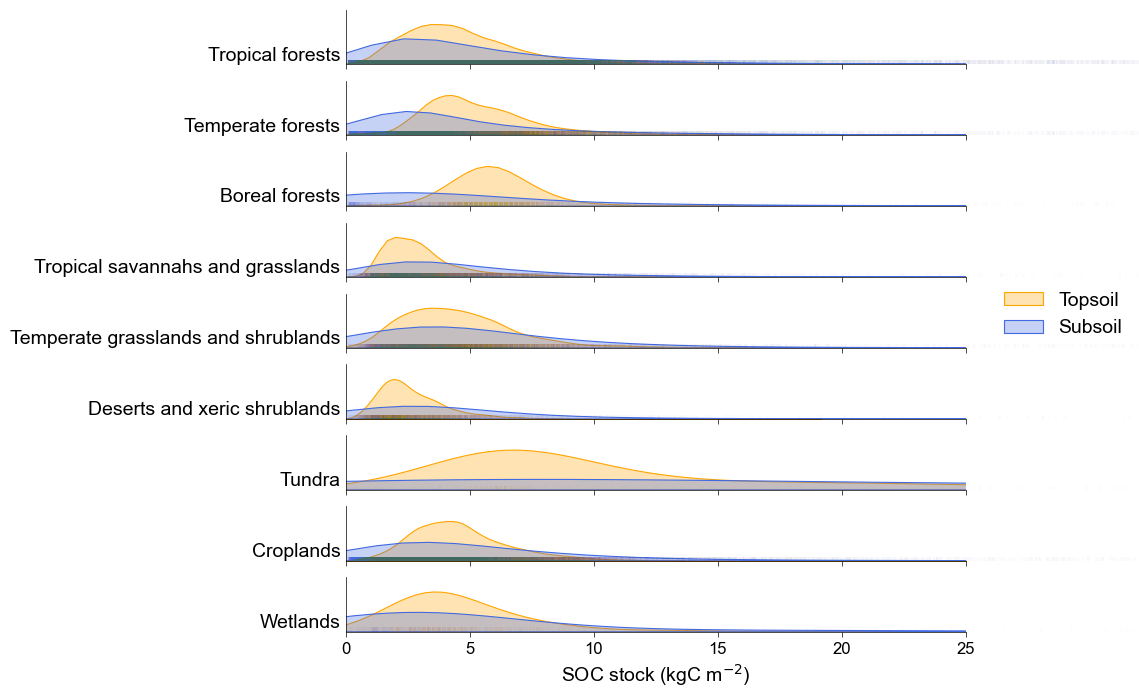

In [162]:
var_name = 'socs'
var_name_show = 'SOC stock (kgC m$^{-2}$)'

vmin = 0
vmax = 25
xticks = [0, 5, 10, 15, 20, 25]
bins = 500

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list_with_global[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list_topsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Topsoil'][var_name])
    value_list_subsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Subsoil'][var_name])
    
    sns.distplot(value_list_topsoil, hist=False, bins=bins, kde=True, rug=True, label='Topsoil', color='orange',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'orange', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    sns.distplot(value_list_subsoil, hist=False, bins=bins, kde=True, rug=True, label='Subsoil', color='royalblue',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'royalblue', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

    if plt_id == 5:
        plt.legend(loc='lower right', bbox_to_anchor=(1.28, -0.12), fontsize=14, frameon=False)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

## SOC turnover time

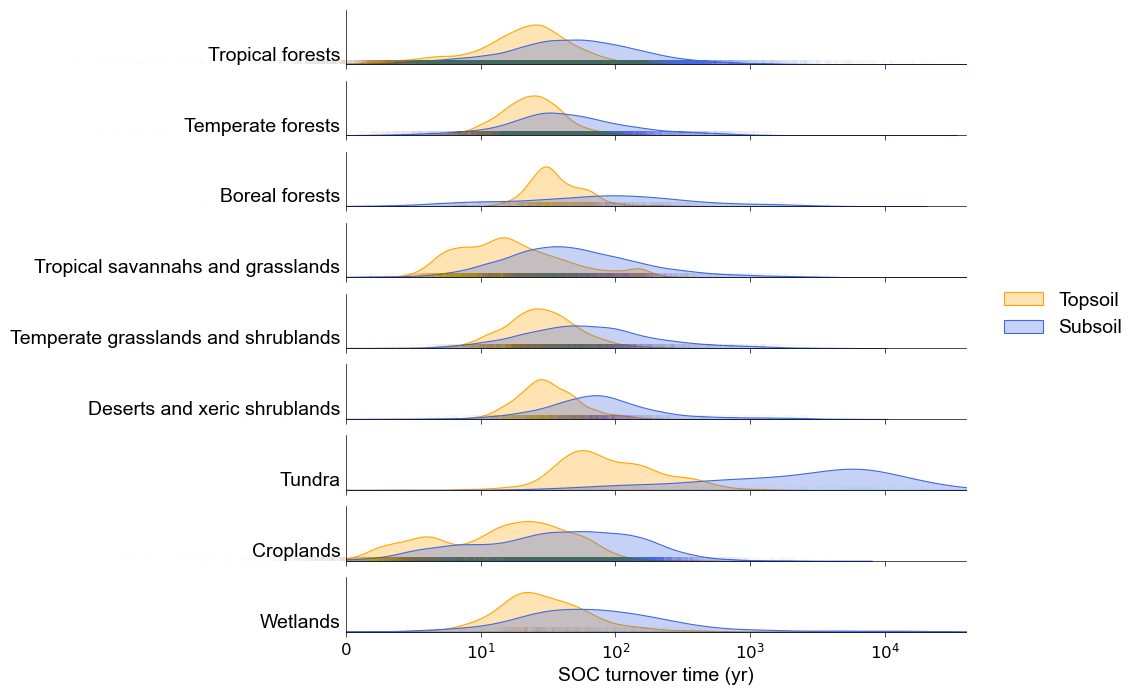

In [164]:
var_name = 'tovr_log'
var_name_show = 'SOC turnover time (yr)'

vmin = 0
vmax = 4.6
xticks = [0, 1, 2, 3, 4]
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list_with_global[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list_topsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Topsoil'][var_name])
    value_list_subsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Subsoil'][var_name])
    
    sns.distplot(value_list_topsoil, hist=False, bins=bins, kde=True, rug=True, label='Topsoil', color='orange',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'orange', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    sns.distplot(value_list_subsoil, hist=False, bins=bins, kde=True, rug=True, label='Subsoil', color='royalblue',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'royalblue', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=["$0$", "$10^{1}$", "$10^{2}$", "$10^{3}$", "$10^{4}$"])
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

    if plt_id == 5:
        plt.legend(loc='lower right', bbox_to_anchor=(1.28, -0.12), fontsize=14, frameon=False)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

## Bulk density

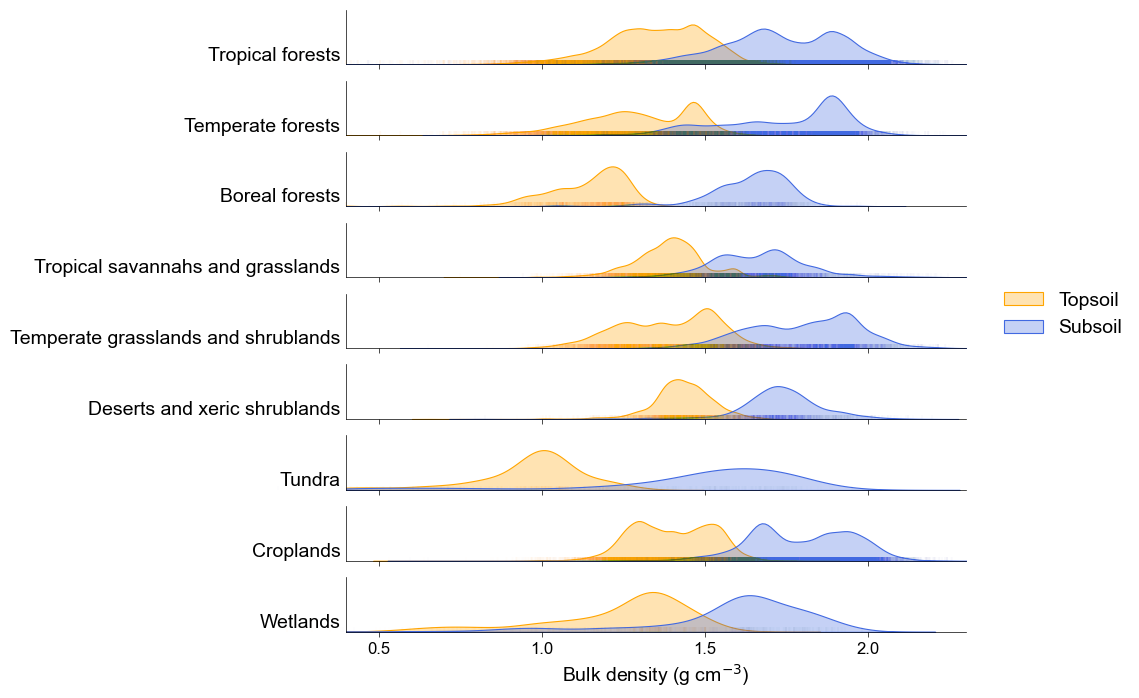

In [166]:
var_name = 'bdod'
var_name_topsoil = f'{var_name}_0to30'
var_name_subsoil = f'{var_name}_30to100'
var_name_show = 'Bulk density (g cm$^{-3}$)'

vmin = 0.4
vmax = 2.3
xticks = [0.5, 1.0, 1.5, 2.0]
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list_with_global[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list_topsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Topsoil'][var_name_topsoil])
    value_list_subsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Subsoil'][var_name_subsoil])
    
    sns.distplot(value_list_topsoil, hist=False, bins=bins, kde=True, rug=True, label='Topsoil', color='orange',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'orange', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    sns.distplot(value_list_subsoil, hist=False, bins=bins, kde=True, rug=True, label='Subsoil', color='royalblue',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'royalblue', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

    if plt_id == 5:
        plt.legend(loc='lower right', bbox_to_anchor=(1.28, -0.12), fontsize=14, frameon=False)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

## Coarse fragments

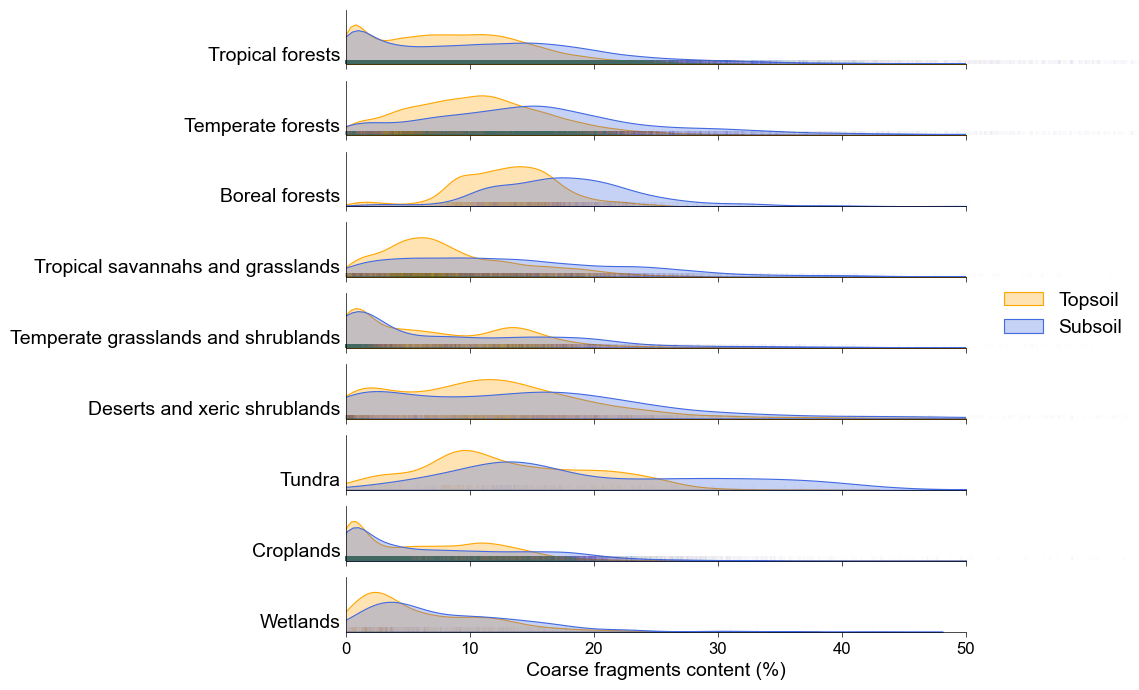

In [168]:
var_name = 'cfvo'
var_name_topsoil = f'{var_name}_0to30'
var_name_subsoil = f'{var_name}_30to100'
var_name_show = 'Coarse fragments content (%)'

vmin = 0.0
vmax = 50
xticks = [0, 10, 20, 30, 40, 50]
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list_with_global[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list_topsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Topsoil'][var_name_topsoil])
    value_list_subsoil = np.array(df_one_biome[df_one_biome['layer'] == 'Subsoil'][var_name_subsoil])
    
    sns.distplot(value_list_topsoil, hist=False, bins=bins, kde=True, rug=True, label='Topsoil', color='orange',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'orange', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    sns.distplot(value_list_subsoil, hist=False, bins=bins, kde=True, rug=True, label='Subsoil', color='royalblue',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': 'royalblue', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

    if plt_id == 5:
        plt.legend(loc='lower right', bbox_to_anchor=(1.28, -0.12), fontsize=14, frameon=False)

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

## Belowground biomass carbon fraction

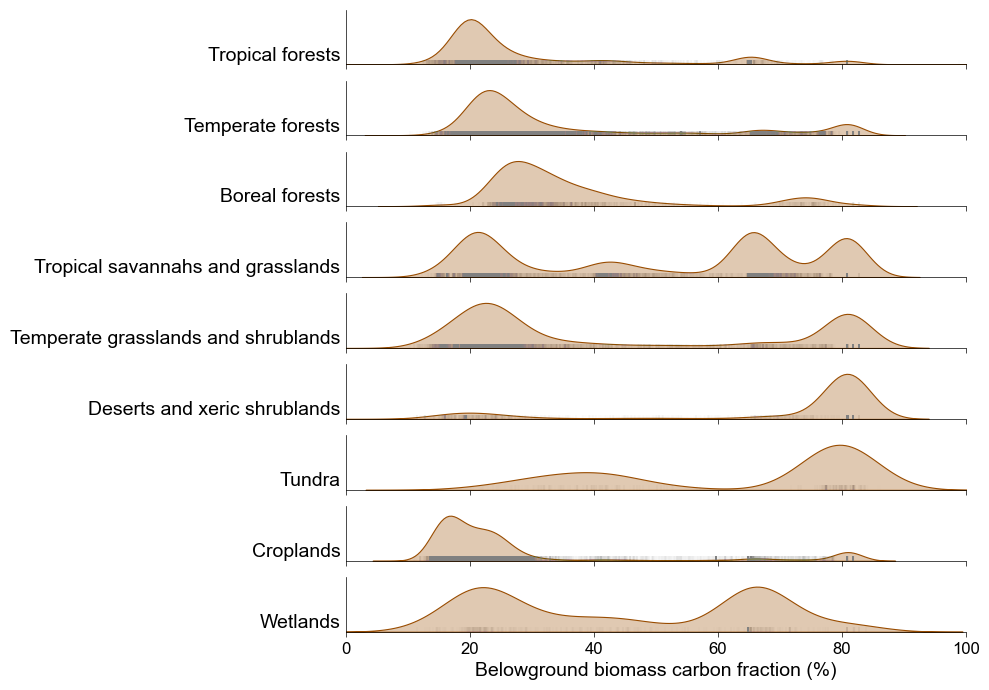

In [176]:
var_name = 'fbgb'
var_name_show = 'Belowground biomass carbon fraction (%)'

vmin = 0.0
vmax = 1.0
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xticks_show = [0, 20, 40, 60, 80, 100]
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list = np.array(df_one_biome[var_name])
    
    sns.distplot(value_list, hist=False, bins=bins, kde=True, rug=True, label=biome_name_list[i], color='#994C00',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': '#808080', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.7}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks_show)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

## Fraction of root in top- and subsoil

## Climate

In [177]:
df_top_sub[['MAT', 'MAP']].describe().round(1)

,MAT,MAP
count,161879.0,161879.0
mean,14.6,932.1
std,7.6,514.4
min,-20.0,3.0
25%,9.6,566.0
50%,14.6,889.0
75%,20.4,1140.0
max,30.5,7129.0


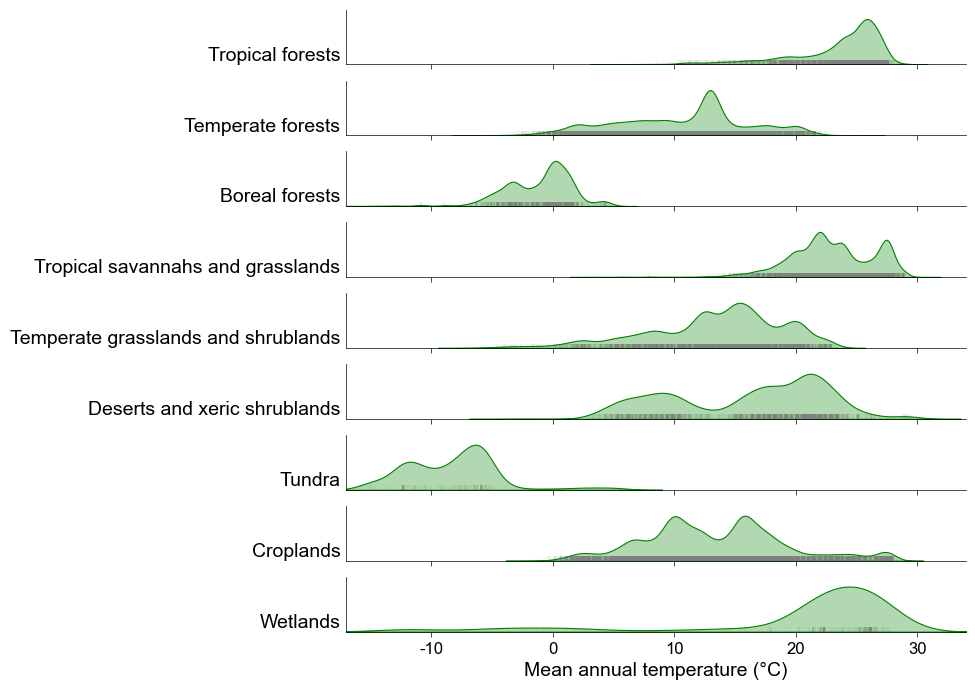

In [179]:
var_name = 'MAT'
var_name_show = 'Mean annual temperature (°C)'

vmin = -17.0
vmax = 34.0
xticks = [-10, 0, 10, 20, 30]
xticks_show = xticks
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list = np.array(df_one_biome[var_name])
    
    sns.distplot(value_list, hist=False, bins=bins, kde=True, rug=True, label=biome_name_list[i], color='green',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': '#808080', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks_show)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

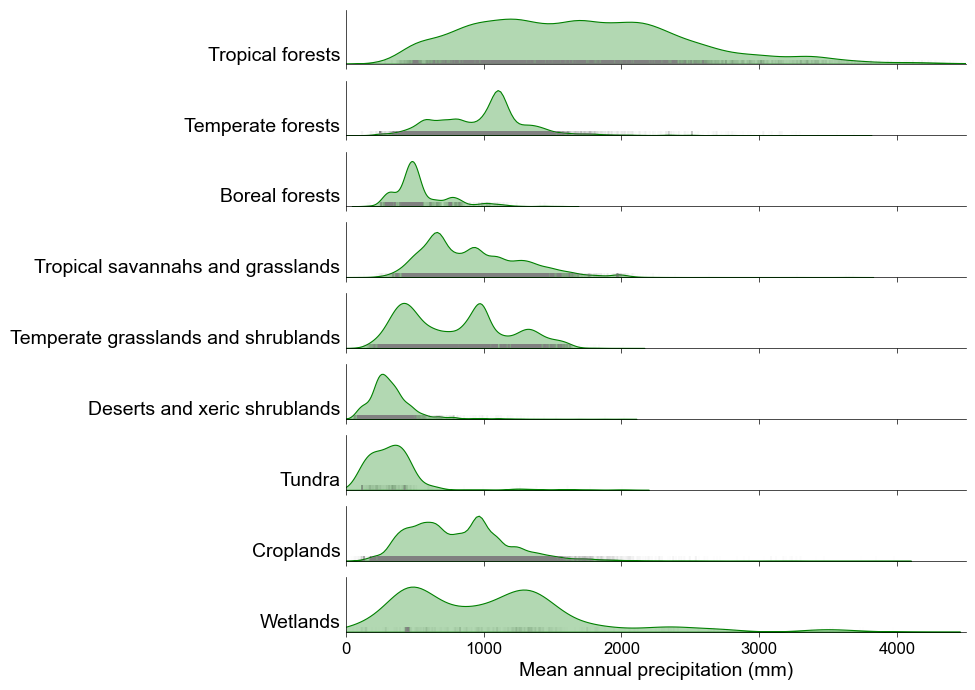

In [180]:
var_name = 'MAP'
var_name_show = 'Mean annual precipitation (mm)'

vmin = 0
vmax = 4500
xticks = [0, 1000, 2000, 3000, 4000]
xticks_show = xticks
bins = 300

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.5)
plt.figure(figsize=(8, 9), dpi=100, linewidth=0.5)

plt_id = 0
for i in range(len(biome_name_list)):
    plt_id += 1
    plt.subplot(10, 1, plt_id)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', width=0.5)

    if biome_name_list[i] == 'Global':
        df_one_biome = df_top_sub.copy()
    else:
        df_one_biome = df_top_sub[df_top_sub['biome_type_name'] == biome_name_list[i]].reset_index(drop=True)
    # df_one_biome = df_one_biome[df_one_biome[var_name] > 0.1].reset_index(drop=True)
    
    value_list = np.array(df_one_biome[var_name])
    
    sns.distplot(value_list, hist=False, bins=bins, kde=True, rug=True, label=biome_name_list[i], color='green',
                 hist_kws={'alpha': 0.3}, rug_kws={'color': '#808080', 'height': 0.08, 'linewidth': 0.01, 'clip_on': False, 'alpha': 0.8}, kde_kws={'linewidth': 0.8, 'fill': True, 'alpha': 0.3})
    
    if plt_id < 9:
        plt.xticks(ticks=xticks, labels=[])
    
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.ylabel(biome_name_list[i], rotation='horizontal', ha='right', rotation_mode='anchor', fontsize=14, y=0.0)

    if plt_id == 9:
        plt.xticks(ticks=xticks, labels=xticks_show)
        plt.xlabel(var_name_show, fontdict={'style': 'normal', 'fontsize': 14})

plt.subplots_adjust(hspace=0.3)

plt.savefig('./figure/sample_data_probability_distributions/sample_density_distribution_biomes_top_sub_{}.jpg'.format(var_name), dpi=600, bbox_inches='tight')
plt.show()

# Plot turnover time along latitude

In [12]:
# map_pred_top = xr.open_rasterio('./results/predmaps_QRF/pred_map_topsoil_QRF_tovr_pred_mean.tif')
# map_pred_sub = xr.open_rasterio('./results/predmaps_QRF/pred_map_subsoil_QRF_tovr_pred_mean.tif')
map_pred_top = xr.open_rasterio('./results/predmaps_QRF/pred_map_topsoil_QRF_tovr_pred_mean_rm_organic_soil.tif')
map_pred_sub = xr.open_rasterio('./results/predmaps_QRF/pred_map_subsoil_QRF_tovr_pred_mean_rm_organic_soil.tif')

# map_pred.values = np.exp(10, map_pred.values, where=~np.isnan(map_pred.values))

# mask_npp = gpd.read_file('./data/mask_npp/mask_npp_vector.shp')
# map_pred = map_pred.rio.write_crs('WGS84').rio.clip(mask_npp.geometry)
map_pred_top.close()
map_pred_sub.close()

In [13]:
def q_lower(x):
    return x.quantile(0.025)

def q_upper(x):
    return x.quantile(0.975)

In [14]:
df_top = map_pred_top[0].to_dataframe(name='tovr_top').reset_index()
df_top = df_top[['y', 'x', 'tovr_top']].reset_index(drop=True)
df_top = df_top.dropna()
df_top = df_top[df_top['tovr_top'] > 0]
df_top = df_top.groupby('y', as_index=False).agg({'tovr_top': [np.mean, q_lower, q_upper]})
df_top.columns = df_top.columns.droplevel(0)
df_top.columns = ['lat', 'tovr_top_mean', 'tovr_top_lower', 'tovr_top_upper']

df_sub = map_pred_sub[0].to_dataframe(name='tovr_sub').reset_index()
df_sub = df_sub[['y', 'x', 'tovr_sub']].reset_index(drop=True)
df_sub = df_sub.dropna()
df_sub = df_sub[df_sub['tovr_sub'] > 0]
df_sub = df_sub.groupby('y', as_index=False).agg({'tovr_sub': [np.mean, q_lower, q_upper]})
df_sub.columns = df_sub.columns.droplevel(0)
df_sub.columns = ['lat', 'tovr_sub_mean', 'tovr_sub_lower', 'tovr_sub_upper']

df_tovr_lat = pd.merge(left=df_top, right=df_sub, on='lat')
# lat_upper = 71.02
lat_upper = 75
lat_lower = -55
df_tovr_lat = df_tovr_lat[df_tovr_lat['lat'] <= lat_upper].reset_index(drop=True)
df_tovr_lat = df_tovr_lat[df_tovr_lat['lat'] >= lat_lower].reset_index(drop=True)
# for colname in df_tovr_lat.columns[1:]:
#     df_tovr_lat[colname] = np.log10(df_tovr_lat[colname])
print(df_tovr_lat.shape)
df_tovr_lat.head()

(1560, 7)


,lat,tovr_top_mean,tovr_top_lower,tovr_top_upper,tovr_sub_mean,tovr_sub_lower,tovr_sub_upper
0,-54.958333,37.862419,33.218211,41.768584,193.755749,115.741110,334.688849
1,-54.875000,36.372775,30.582338,44.575007,265.529106,77.091907,536.060625
2,-54.791667,38.070894,27.843571,48.980254,246.808713,80.791893,587.136071
3,-54.708333,37.558866,27.910743,48.475044,212.922268,83.862995,574.904913
4,-54.625000,37.101502,29.431601,46.976730,246.657287,68.479357,501.748538


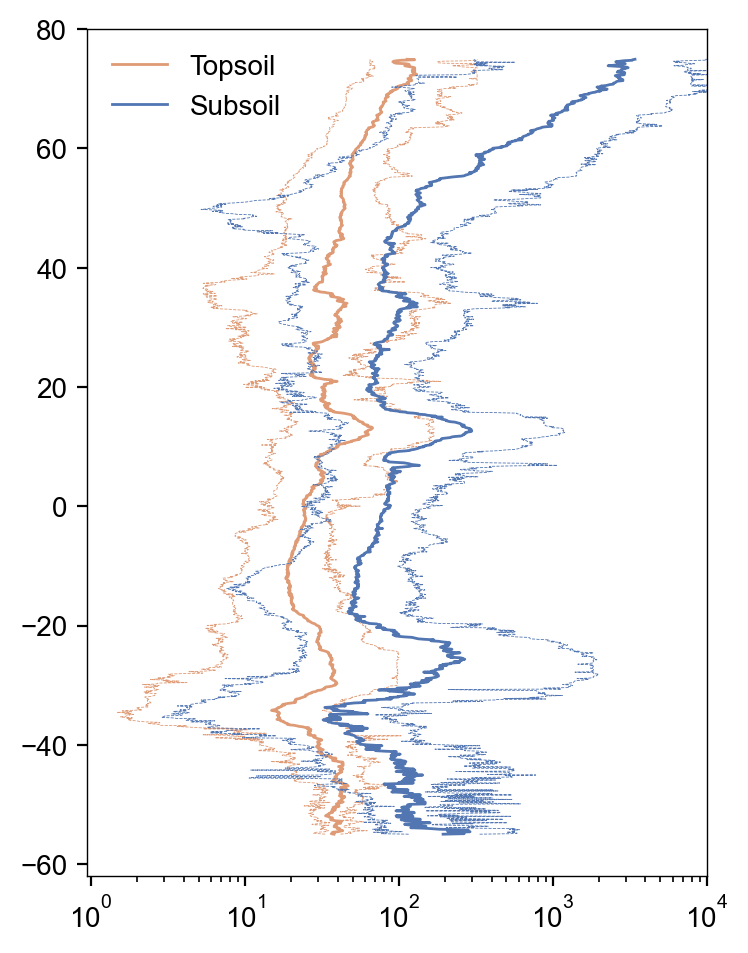

In [16]:
plt.rc('font', family='Arial', size=10)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)
# plt.figure(figsize=(4, 5), dpi=200, linewidth=0.1, frameon=False)
plt.figure(figsize=(4, 5.5), dpi=200, linewidth=0.1, frameon=False)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

plt.plot(df_tovr_lat['tovr_top_mean'], df_tovr_lat['lat'], color='#DF9B76', linewidth=1, linestyle='-', label='Topsoil')
plt.plot(df_tovr_lat['tovr_top_lower'], df_tovr_lat['lat'], color='#DF9B76', linewidth=0.3, linestyle='--')
plt.plot(df_tovr_lat['tovr_top_upper'], df_tovr_lat['lat'], color='#DF9B76', linewidth=0.3, linestyle='--')

plt.plot(df_tovr_lat['tovr_sub_mean'], df_tovr_lat['lat'], color='#5176B2', linewidth=1, linestyle='-', label='Subsoil')
plt.plot(df_tovr_lat['tovr_sub_lower'], df_tovr_lat['lat'], color='#5176B2', linewidth=0.3, linestyle='--')
plt.plot(df_tovr_lat['tovr_sub_upper'], df_tovr_lat['lat'], color='#5176B2', linewidth=0.3, linestyle='--')

plt.gca().set_xscale('log')
plt.xlim(0, 10**4)
plt.ylim(-62, 80)
plt.xlabel('')
plt.ylabel('')
plt.legend(loc=2, fontsize=10, frameon=False)

plt.savefig('./figure/tovr_vs_latitude.jpg', dpi=600, bbox_inches='tight')
plt.show()

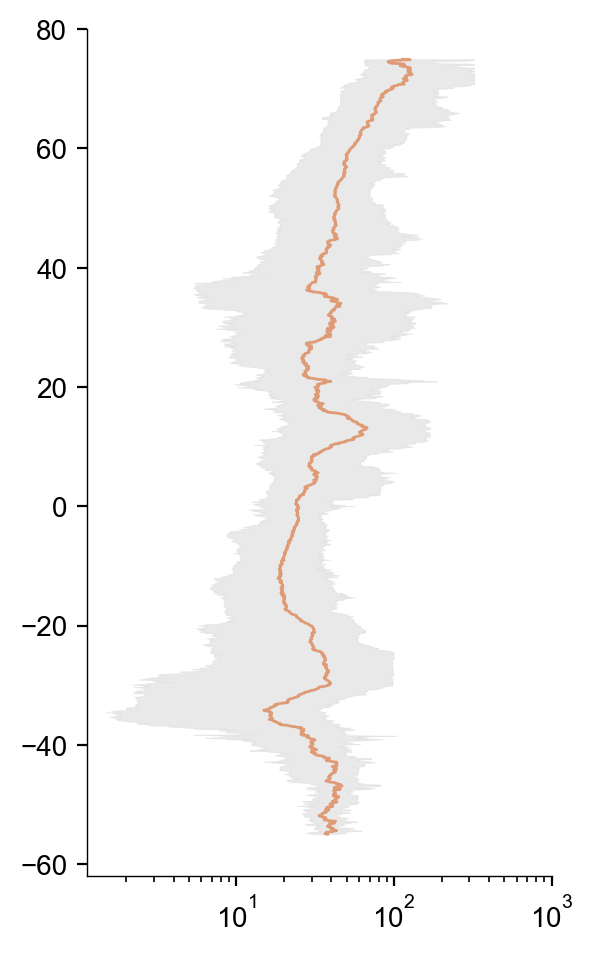

In [17]:
plt.rc('font', family='Arial', size=10)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)
# plt.figure(figsize=(4, 5), dpi=200, linewidth=0.1, frameon=False)
plt.figure(figsize=(3, 5.5), dpi=200, linewidth=0.1, frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_tovr_lat['tovr_top_mean'], df_tovr_lat['lat'], color='#DF9B76', linewidth=1, linestyle='-')

plt.fill_betweenx(y=df_tovr_lat['lat'], x1=df_tovr_lat['tovr_top_lower'], x2=df_tovr_lat['tovr_top_upper'], linewidth=0.3, alpha=.7, color='#E0E0E0')

plt.gca().set_xscale('log')
# plt.xticks([0, 10, 10**2, 10**3])
plt.xlim(0, 10**3)
plt.ylim(-62, 80)
plt.xlabel('')
plt.ylabel('')
# plt.legend(loc=2, fontsize=10, frameon=False)

plt.savefig('./figure/tovr_vs_latitude_topsoil.jpg', dpi=600, bbox_inches='tight')
plt.show()

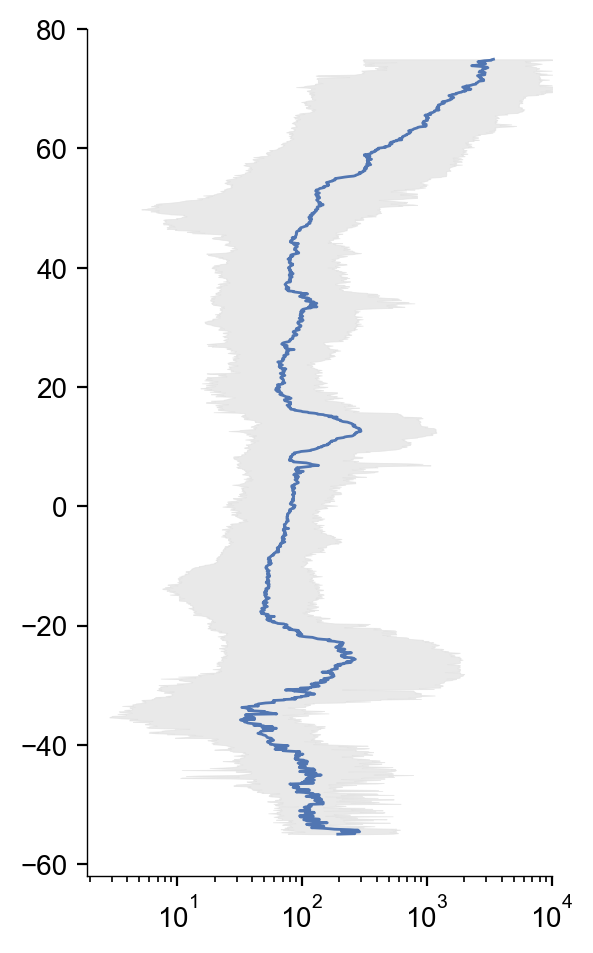

In [18]:
plt.rc('font', family='Arial', size=10)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)
# plt.figure(figsize=(4, 5), dpi=200, linewidth=0.1, frameon=False)
plt.figure(figsize=(3, 5.5), dpi=200, linewidth=0.1, frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.plot(df_tovr_lat['tovr_sub_mean'], df_tovr_lat['lat'], color='#5176B2', linewidth=1, linestyle='-')

plt.fill_betweenx(y=df_tovr_lat['lat'], x1=df_tovr_lat['tovr_sub_lower'], x2=df_tovr_lat['tovr_sub_upper'], linewidth=0.3, alpha=.7, color='#E0E0E0')

plt.gca().set_xscale('log')
# plt.xticks([0, 10, 10**2, 10**3])
plt.xlim(0, 10**4)
plt.ylim(-62, 80)
plt.xlabel('')
plt.ylabel('')
# plt.legend(loc=2, fontsize=10, frameon=False)

plt.savefig('./figure/tovr_vs_latitude_subsoil.jpg', dpi=600, bbox_inches='tight')
plt.show()

# Plot turnover time in global biomes

44.63120653812787 384.95158075001365


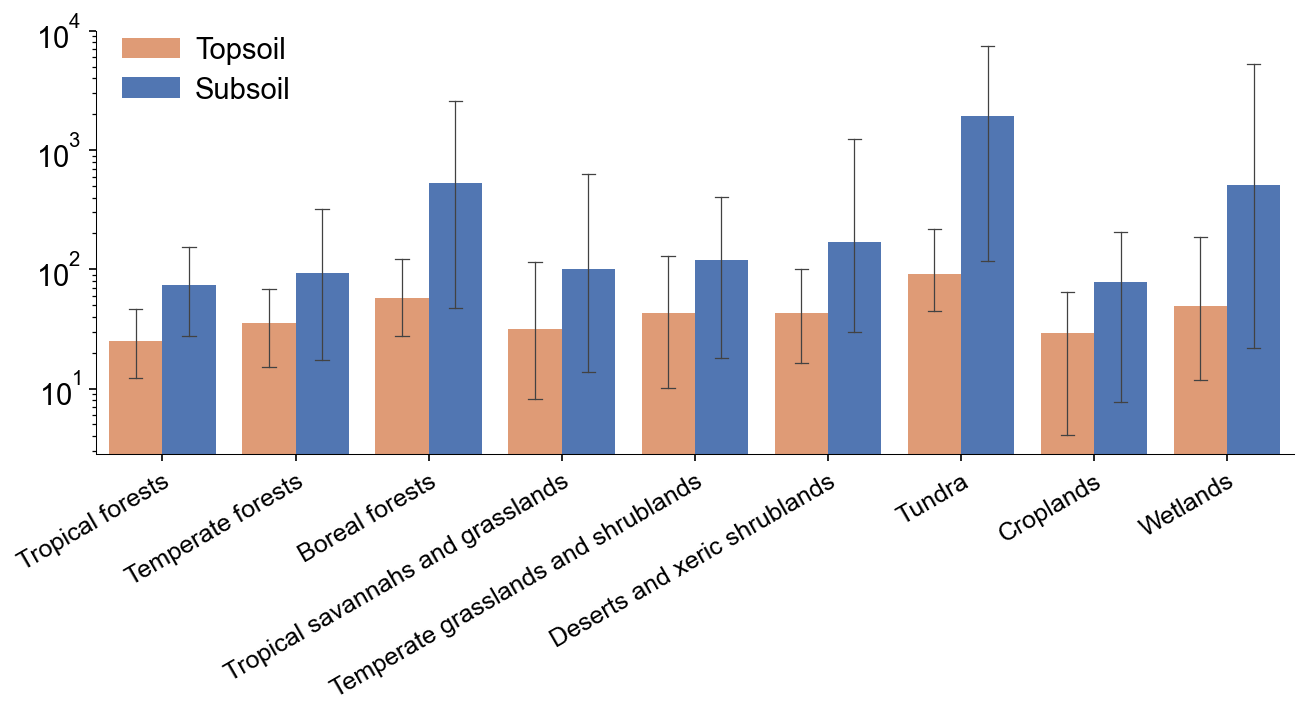

In [62]:
plt.rc('font', family='Arial', size=14)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)
fig = plt.figure(figsize=(9, 5), dpi=150, linewidth=0.1, frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

biome_order = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts and xeric shrublands', 'Tundra', 'Croplands', 'Wetlands']
sns.barplot(x='biome_type_name', y='tovr', data=df_pred_all_, hue='layer', hue_order=['Topsoil', 'Subsoil'], order=biome_order,
            estimator=np.mean,
            errorbar=('pi', 95), capsize=0.2, errwidth=0.6, saturation=1,
            palette=['#DF9B76', '#5176B2'])

plt.legend(loc='upper left', bbox_to_anchor=(0, 0, 0, 1.05), frameon=False,
           fontsize=14, labelspacing=0.4, handletextpad=0.5)
# plt.legend(bbox_to_anchor=(0.995, 0.205, 1, 0), loc='upper left', frameon=False,
#            fontsize=10, labelspacing=0.4, handletextpad=0.5)

tovr_mean_top = np.mean(df_pred_all_[df_pred_all_['layer'] == 'Topsoil']['tovr'])
tovr_mean_sub = np.mean(df_pred_all_[df_pred_all_['layer'] == 'Subsoil']['tovr'])
# tovr_mean_top = np.median(df_pred_all_[df_pred_all_['layer'] == 'Topsoil']['tovr'])
# tovr_mean_sub = np.median(df_pred_all_[df_pred_all_['layer'] == 'Subsoil']['tovr'])
print(tovr_mean_top, tovr_mean_sub)
# plt.plot([-0.5, 8.5], [tovr_mean_top, tovr_mean_top], c='#DF9B76', linestyle='--', linewidth=1)
# plt.plot([-0.5, 8.5], [tovr_mean_sub, tovr_mean_sub], c='#5176B2', linestyle='--', linewidth=1)

plt.xticks(rotation=30, ha='right', rotation_mode='anchor', fontsize=12)
plt.yticks([10, 10**2, 10**3, 10**4])

plt.xlabel('')
plt.ylabel('')
plt.gca().set_yscale('log')
plt.xlim(-0.5, 8.5)
plt.ylim(0, 10**4)
plt.tight_layout()

plt.savefig('./figure/stats_tovr_in_global_biomes.jpg', dpi=600, bbox_inches='tight')
plt.show()